In [1]:
'''
# 패키지가 설치되지 않았을 경우: "!pip install [패키지명]" 실행
!pip install matplotlib
!pip install scikit-learn
'''

# 필요한 패키지 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# random seed 고정
random.seed(42)
np.random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # multi-GPU 사용 시
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# 다중클래스 분류를 위한 새로운 데이터 입력
from sklearn.datasets import load_digits

digits = load_digits()
images = digits.images;  labels = digits.target

print(images.shape, labels.shape)

(1797, 8, 8) (1797,)


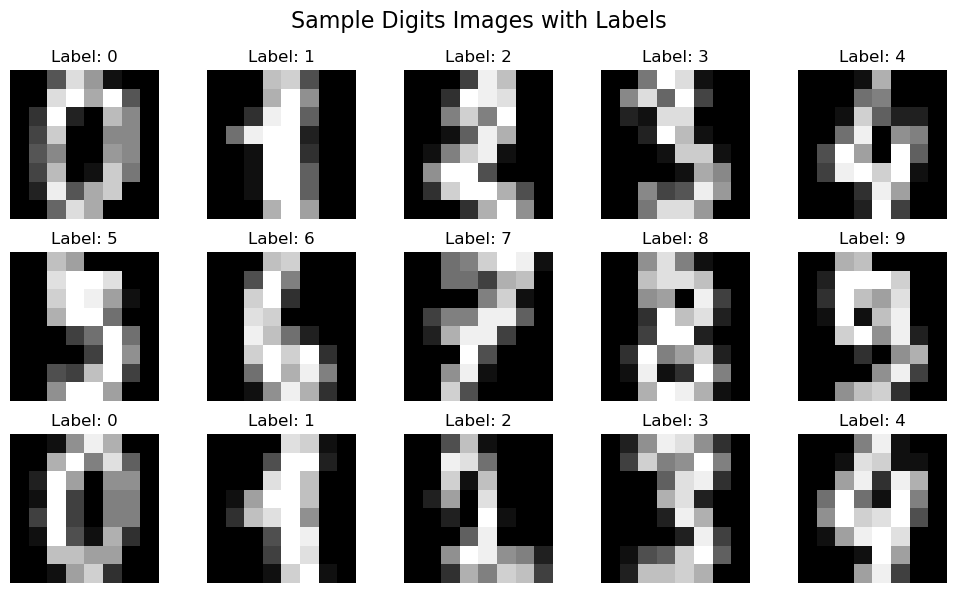

In [4]:
# 이미지 데이터 시각화
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(15):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')

plt.suptitle("Sample Digits Images with Labels", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
# Flatten (MLP용 벡터화)
images = images.reshape((len(images), -1)).astype(np.float32)  # (1797, 64)
print(images.shape, labels.shape)

(1797, 64) (1797,)


In [6]:
# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1257, 64) (1257,) (540, 64) (540,)


In [7]:
print(pd.Series(y_train).value_counts())

3    128
1    127
5    127
6    127
4    127
9    126
7    125
0    124
2    124
8    122
dtype: int64


In [8]:
print(pd.Series(y_test).value_counts())

1    55
3    55
5    55
0    54
6    54
7    54
4    54
9    54
2    53
8    52
dtype: int64


In [9]:
# 데이터 표준화: Min-max scaler (0-1 사이 변환), Standard scaler (표준정규화)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# 장치(CPU/GPU) 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [11]:
# Tensor로 변환
X_train_tensor = torch.tensor(X_train).to(device)
X_test_tensor = torch.tensor(X_test).to(device)
y_train_tensor = torch.tensor(y_train).to(device).long() # torch.long: 64비트 정수 (주로 레이블에 사용)
y_test_tensor = torch.tensor(y_test).to(device).long()

In [12]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

model = MLP().to(device)


In [13]:
# 손실함수와 최적화함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# MLP 모델 학습
epochs = 300
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"[Epoch {epoch+1}/{epochs}] Loss: {loss.item():.4f}")

[Epoch 10/300] Loss: 2.0415
[Epoch 20/300] Loss: 1.6294
[Epoch 30/300] Loss: 1.1148
[Epoch 40/300] Loss: 0.6726
[Epoch 50/300] Loss: 0.3973
[Epoch 60/300] Loss: 0.2479
[Epoch 70/300] Loss: 0.1675
[Epoch 80/300] Loss: 0.1196
[Epoch 90/300] Loss: 0.0887
[Epoch 100/300] Loss: 0.0673
[Epoch 110/300] Loss: 0.0521
[Epoch 120/300] Loss: 0.0410
[Epoch 130/300] Loss: 0.0327
[Epoch 140/300] Loss: 0.0265
[Epoch 150/300] Loss: 0.0218
[Epoch 160/300] Loss: 0.0182
[Epoch 170/300] Loss: 0.0154
[Epoch 180/300] Loss: 0.0132
[Epoch 190/300] Loss: 0.0114
[Epoch 200/300] Loss: 0.0100
[Epoch 210/300] Loss: 0.0088
[Epoch 220/300] Loss: 0.0078
[Epoch 230/300] Loss: 0.0070
[Epoch 240/300] Loss: 0.0063
[Epoch 250/300] Loss: 0.0057
[Epoch 260/300] Loss: 0.0051
[Epoch 270/300] Loss: 0.0047
[Epoch 280/300] Loss: 0.0043
[Epoch 290/300] Loss: 0.0040
[Epoch 300/300] Loss: 0.0037


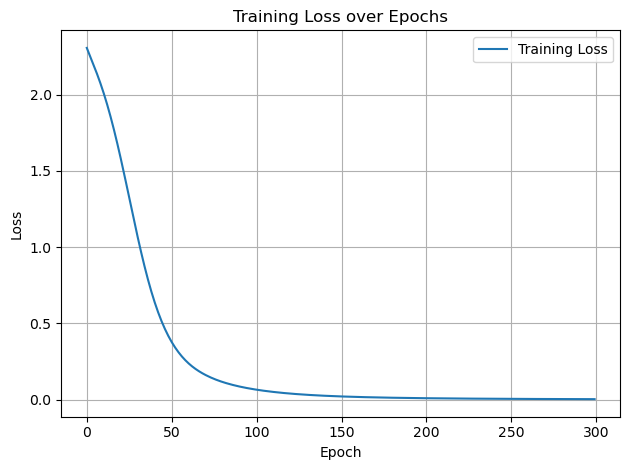

In [15]:
# 손실 값 시각화
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# MLP 모델 평가
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    y_pred = predicted.cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()
    y_prob = torch.softmax(outputs, dim=1).cpu().numpy()

In [17]:
# Class 예측
y_pred

array([1, 3, 1, 5, 0, 6, 6, 7, 4, 9, 3, 9, 7, 7, 6, 1, 5, 7, 3, 3, 9, 8,
       5, 5, 4, 4, 9, 3, 2, 3, 6, 0, 2, 0, 4, 6, 1, 2, 5, 5, 2, 3, 1, 3,
       2, 6, 5, 8, 9, 6, 0, 4, 6, 5, 1, 6, 6, 6, 2, 3, 1, 2, 9, 9, 4, 6,
       1, 5, 0, 9, 9, 8, 4, 7, 7, 9, 0, 0, 4, 9, 5, 4, 1, 9, 0, 0, 5, 6,
       5, 7, 3, 5, 3, 1, 5, 9, 2, 3, 9, 7, 4, 0, 0, 9, 2, 7, 3, 1, 4, 9,
       3, 8, 2, 5, 1, 1, 6, 9, 4, 3, 7, 1, 8, 1, 9, 7, 9, 0, 3, 2, 7, 7,
       2, 4, 0, 8, 7, 1, 5, 7, 2, 4, 2, 9, 5, 9, 5, 4, 4, 2, 0, 3, 3, 7,
       2, 5, 1, 5, 1, 0, 6, 7, 7, 3, 2, 3, 1, 0, 7, 3, 0, 7, 4, 9, 2, 5,
       3, 0, 0, 9, 5, 3, 7, 6, 5, 3, 4, 6, 0, 6, 6, 3, 4, 6, 2, 1, 8, 9,
       7, 4, 3, 4, 2, 4, 8, 0, 3, 1, 2, 4, 7, 2, 0, 8, 8, 6, 1, 8, 4, 5,
       1, 0, 2, 8, 4, 2, 0, 1, 6, 8, 3, 5, 8, 3, 1, 9, 0, 4, 6, 2, 9, 6,
       7, 1, 0, 4, 6, 0, 8, 2, 8, 9, 1, 2, 3, 9, 4, 7, 5, 7, 2, 9, 4, 6,
       2, 8, 7, 5, 8, 8, 0, 3, 2, 3, 1, 2, 6, 8, 5, 2, 8, 3, 1, 3, 0, 5,
       3, 1, 7, 2, 0, 1, 0, 9, 7, 9, 2, 3, 5, 3, 0,

In [18]:
# 각 Class에 할당될 확률 예측
pd.DataFrame(y_prob)

,0,1,2,3,4,5,6,7,8,9
0,6.498722e-10,9.998837e-01,5.758804e-05,0.000001,8.901981e-07,1.553839e-05,3.621404e-05,4.378254e-08,8.992868e-08,4.982568e-06
1,2.991947e-07,7.221934e-06,2.997183e-04,0.999515,1.997851e-07,1.042961e-05,1.095161e-06,6.840248e-05,3.215110e-06,9.398473e-05
2,2.968605e-07,9.984717e-01,2.456275e-05,0.000009,2.912097e-04,8.241932e-06,1.322281e-05,3.639174e-04,7.952371e-04,2.240330e-05
3,1.863278e-08,5.676808e-08,1.034184e-08,0.000010,1.940024e-08,9.999793e-01,5.935439e-08,1.089137e-05,3.517068e-08,2.081917e-07
4,9.999257e-01,1.699448e-08,3.968741e-07,0.000001,2.133528e-06,6.742006e-06,6.207140e-05,5.010546e-07,1.121899e-07,1.217137e-06
...,...,...,...,...,...,...,...,...,...,...
535,8.029584e-05,3.292556e-06,4.086824e-07,0.000007,4.905431e-04,3.493043e-04,9.474922e-07,9.989644e-01,9.496950e-07,1.027799e-04
536,4.543641e-06,1.254980e-05,2.700277e-06,0.000034,4.315481e-05,1.737071e-05,9.507381e-07,5.201851e-05,2.654370e-03,9.971780e-01
537,1.884191e-06,2.479266e-05,3.179183e-06,0.000024,2.795586e-05,3.273763e-06,9.995114e-01,1.843668e-07,4.026056e-04,1.923250e-07
538,8.509498e-08,9.996790e-01,1.186137e-05,0.000029,2.018183e-05,8.529164e-07,2.436518e-06,1.080443e-05,4.004277e-05,2.061093e-04


In [19]:
# 분류 평가 지표: Confusion matrix
confusion_matrix(y_true, y_pred)

array([[53,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 54,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 53,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 55,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 52,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  0,  0, 54,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 53,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  0],
       [ 0,  4,  1,  1,  0,  0,  0,  0, 46,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 54]], dtype=int64)

In [20]:
# 분류 평가 지표: Precision, Recall, F1 score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.93      0.98      0.96        55
           2       0.98      1.00      0.99        53
           3       0.96      1.00      0.98        55
           4       0.98      0.96      0.97        54
           5       1.00      0.98      0.99        55
           6       1.00      0.98      0.99        54
           7       0.98      1.00      0.99        54
           8       0.96      0.88      0.92        52
           9       0.98      1.00      0.99        54

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



## (1) K-fold Cross Validation

In [21]:
# MLP 모델 정의
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)

In [22]:
# K-Fold 설정
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# 정확도 기준 성능 평가
scores = cross_val_score(mlp, X_train, y_train, cv=cv, scoring='accuracy')
print(f'각 fold 정확도: {scores}')
print(f'평균 정확도: {np.mean(scores):.4f}')

각 fold 정확도: [0.96031746 0.98412698 0.94820717 0.98406375 0.98007968]
평균 정확도: 0.9714


## (2) Grid Search 기반 Hyperparameter Tuning

In [24]:
from sklearn.model_selection import GridSearchCV

# Grid Search 탐색 공간 정의
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (100,), (50, 30, 10)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

# Grid Search 모델 정의
grid_search = GridSearchCV(MLPClassifier(max_iter=300), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

In [25]:
# Grid Search 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 조합/점수 반환
print("Best params:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best CV accuracy: 0.9777247414478918


## (3) 클래스 불균형 문제 발생 시, 데이터 증강

In [26]:
# 현재 각 클래스 수 확인
original_counts = Counter(y_train)
original_counts

Counter({0: 124,
         7: 125,
         1: 127,
         3: 128,
         5: 127,
         6: 127,
         4: 127,
         8: 122,
         2: 124,
         9: 126})

In [27]:
from imblearn.over_sampling import SMOTE

# 1번 클래스와 7번 클래스만 2배로 늘리기
smote_target = {
    1: original_counts[1] * 3,
    8: original_counts[8] * 3
}

# SMOTE 적용
smote = SMOTE(sampling_strategy=smote_target, random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape)
print(X_res.shape, y_res.shape)

C:\Users\ysbye\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (381) in class 1 will be larger than the number of samples in the majority class (class #3 -> 128)
  warnings.warn(
C:\Users\ysbye\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (366) in class 8 will be larger than the number of samples in the majority class (class #3 -> 128)
  warnings.warn(


(1257, 64) (1257,)
(1755, 64) (1755,)


In [28]:
# 현재 각 클래스 수 확인
augmented_counts = Counter(y_res)
augmented_counts

Counter({0: 124,
         7: 125,
         1: 381,
         3: 128,
         5: 127,
         6: 127,
         4: 127,
         8: 366,
         2: 124,
         9: 126})

In [29]:
# MLP 모델 정의
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)

# MLP 모델 학습
mlp.fit(X_res, y_res)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)

In [30]:
# MLP 모델 평가
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.93      0.98      0.96        55
           2       0.98      1.00      0.99        53
           3       1.00      1.00      1.00        55
           4       0.98      0.98      0.98        54
           5       1.00      0.98      0.99        55
           6       0.98      0.96      0.97        54
           7       1.00      1.00      1.00        54
           8       0.96      0.92      0.94        52
           9       0.98      1.00      0.99        54

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



## (4) 효율적인 학습을 위한 early stopping

In [41]:
# MLPClassifier 모델 정의 (Early Stopping 활성화)
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=1000,
    early_stopping=True,  # Early stopping 활성화
    validation_fraction=0.1,  # 검증 데이터 비율
    n_iter_no_change=50,  # 성능 개선이 없으면 10번 후 중지
    random_state=42
)

# 학습
mlp.fit(X_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 64), max_iter=1000,
              n_iter_no_change=50, random_state=42)

In [42]:
# 예측 및 성능 평가
y_pred = mlp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9685185185185186
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        54
           1       0.92      0.98      0.95        55
           2       0.95      1.00      0.97        53
           3       1.00      0.98      0.99        55
           4       0.98      0.94      0.96        54
           5       1.00      0.95      0.97        55
           6       1.00      0.98      0.99        54
           7       0.95      1.00      0.97        54
           8       0.96      0.88      0.92        52
           9       0.95      1.00      0.97        54

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



In [43]:
# Early Stopping 관련 정보 출력
print("Number of iterations before stopping:", mlp.n_iter_)

Number of iterations before stopping: 112
